In [ ]:
import json
import os
import csv
import urllib
import cv2
from io import BytesIO
from PIL import Image
import PIL

import numpy as np
import matplotlib.pyplot as plt

import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from matplotlib import pyplot as plt
from copy import deepcopy
import torch.nn.functional as F
from torch.autograd import Variable
from IPython.display import clear_output
import time

from socket import timeout

from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
images = np.load('/content/drive/My Drive/Colab Notebooks/Paper/imgs.npy')
masks = np.load('/content/drive/My Drive/Colab Notebooks/Paper/masks.npy')
images = np.clip(images,1030,1090)-1030

xy = np.where(masks>0)[1:]
x1,x2,y1,y2 = xy[0].min(),xy[0].max(),xy[1].min(),xy[1].max()
dx,dy = x2-x1+1,y2-y1+1

imgr = np.stack([x[x1:x2+1,y1:y2+1] for x in images])
maskr = np.stack([x[x1:x2+1,y1:y2+1].astype('uint8') for x in masks])

imgr = np.stack([cv2.resize(x, (256,256)) for x in images])
maskr = np.stack([cv2.resize(x.astype('uint8'), (256,256)) for x in masks])

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.Tensor(list(data)).float()
        self.target = torch.Tensor(list(target)).float()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index].resize_((1,256,256))
        y = self.target[index].resize_((1,256,256))
        
        if self.transform:
            data = torch.cat()
            x = self.transform(x)
            x, y = data[0], data[1] 
        return x, y
    
    def __len__(self):
        return len(self.data)


numpy_data = imgr
numpy_target = maskr
batch_size = 5 

dataset = MyDataset(numpy_data, numpy_target)
ind = np.random.permutation(25)
 

train_dataset, test_dataset = torch.utils.data.Subset(dataset, ind[0:20]),torch.utils.data.Subset(dataset, ind[20:25])

train_batch = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

test_batch = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

for batch_idx, (data, target) in enumerate(train_batch):
    print('Batch idx {}, data shape {}, target shape {}'.format(
        batch_idx, data.shape, target.shape))
    

for batch_idx, (data, target) in enumerate(test_batch):
    print('Batch idx {}, data shape {}, target shape {}'.format(
        batch_idx, data.shape, target.shape))

Batch idx 0, data shape torch.Size([5, 1, 256, 256]), target shape torch.Size([5, 1, 256, 256])
Batch idx 1, data shape torch.Size([5, 1, 256, 256]), target shape torch.Size([5, 1, 256, 256])
Batch idx 2, data shape torch.Size([5, 1, 256, 256]), target shape torch.Size([5, 1, 256, 256])
Batch idx 3, data shape torch.Size([5, 1, 256, 256]), target shape torch.Size([5, 1, 256, 256])
Batch idx 0, data shape torch.Size([5, 1, 256, 256]), target shape torch.Size([5, 1, 256, 256])


In [ ]:
class SoftDice():
    def __init__(self):
        pass
  
    def __call__(self, prediction, ground_truth):
        n_images = len(prediction)
        loss = 2*torch.mul(prediction, ground_truth).sum()
        loss/=((prediction.sum()) + (ground_truth.sum()))
        return torch.clamp(loss,min=1e-7,max=1-1e-7)
        
def compute_loss(X, y):
    X = Variable(X).cuda()
    y = Variable(y).cuda()
    logits = model.cuda()(X)
    loss = torch.nn.BCELoss()
    # loss = BCE()
    lossDice = SoftDice()
    # # return loss(logits, y)
    return loss(logits, y) + (1-lossDice(logits, y))
    # # return loss(logits, y) - torch.log(lossDice(logits, y))
    # return 1 - lossDice(logits, y)

class BoundaryLoss(nn.Module):
    def __init__(self, theta0=3, theta=5):
        super().__init__()

        self.theta0 = theta0
        self.theta = theta

    def forward(self, pred, gt):

        n, c, _, _ = pred.shape

        # softmax so that predicted map can be distributed in [0, 1]
        pred = torch.softmax(pred, dim=1)

        # one-hot vector of ground truth
        one_hot_gt = one_hot(gt, c)

        # boundary map
        gt_b = F.max_pool2d(
            1 - one_hot_gt, kernel_size=self.theta0, stride=1, padding=(self.theta0 - 1) // 2)
        gt_b -= 1 - one_hot_gt

        pred_b = F.max_pool2d(
            1 - pred, kernel_size=self.theta0, stride=1, padding=(self.theta0 - 1) // 2)
        pred_b -= 1 - pred

        # extended boundary map
        gt_b_ext = F.max_pool2d(
            gt_b, kernel_size=self.theta, stride=1, padding=(self.theta - 1) // 2)

        pred_b_ext = F.max_pool2d(
            pred_b, kernel_size=self.theta, stride=1, padding=(self.theta - 1) // 2)

        # reshape
        gt_b = gt_b.view(n, c, -1)
        pred_b = pred_b.view(n, c, -1)
        gt_b_ext = gt_b_ext.view(n, c, -1)
        pred_b_ext = pred_b_ext.view(n, c, -1)

        # Precision, Recall
        P = torch.sum(pred_b * gt_b_ext, dim=2) / (torch.sum(pred_b, dim=2) + 1e-7)
        R = torch.sum(pred_b_ext * gt_b, dim=2) / (torch.sum(gt_b, dim=2) + 1e-7)

        # Boundary F1 Score
        BF1 = 2 * P * R / (P + R + 1e-7)

        # summing BF1 Score for each class and average over mini-batch
        loss = torch.mean(1 - BF1)

        return loss

In [ ]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func=func

    def forward(self, x): 
        return torch.FloatTensor(self.func(x.cpu()))

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class DownBlock(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3, activation=F.relu, padding = 1):
        super(DownBlock, self).__init__()
        self.conv0 = nn.Conv2d(in_size, out_size, kernel_size, padding=1)
        self.conv1 = nn.Conv2d(out_size, out_size, kernel_size, padding=1)
        self.conv2 = nn.Conv2d(out_size, out_size, kernel_size, padding=1)
        self.drop = nn.Dropout2d(0.05)
        self.BN1 = nn.BatchNorm2d(out_size)
        self.BN2 = nn.BatchNorm2d(out_size)
        self.activation = activation

    def forward(self, x):
        out = self.activation(self.conv0(x))
        out = self.drop(out)
        # out = self.drop(out)
        # out = self.BN1(out)
        # out = self.activation(self.conv1(out))
        out = self.BN1(out)
        out = self.activation(self.conv2(out))
        out = self.BN2(out)
        out = self.drop(out)
        return out


class MiddleBlock(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3, activation=F.relu, padding = 1):
        super(MiddleBlock, self).__init__()
        self.conv0 = nn.Conv2d(in_size, out_size, kernel_size, padding=1)
        self.activation = activation

    def forward(self, x):
        out = self.activation(self.conv0(x))
        return out


class UpBlock(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3, activation=F.relu, space_dropout=False,padding=1):
        super(UpBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_size, out_size, 2, stride=2)
        self.conv = nn.Conv2d(in_size, out_size, kernel_size,padding=1)
        self.conv2 = nn.Conv2d(out_size, out_size, kernel_size,padding=1)
        self.activation = activation

    def center_crop(self, layer, target_size):
        batch_size, n_channels, layer_width, layer_height = layer.size()
        xy1 = (layer_width - target_size) // 2
        return layer[:, :, xy1:(xy1 + target_size), xy1:(xy1 + target_size)]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.size()[2])
        out = torch.cat([up, crop1], 1)
        out = self.activation(self.conv(out))
        out = self.activation(self.conv2(out))

        return out

class Up(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3, activation=F.relu, space_dropout=False,padding=1):
        super(Up, self).__init__()
        self.conv = nn.Conv2d(in_size, out_size, kernel_size,padding=1)
        self.conv2 = nn.Conv2d(out_size, out_size, kernel_size,padding=1)
        self.activation = activation
        self.BN = nn.BatchNorm2d(out_size)

    def forward(self, x):
        out = self.BN(self.activation(self.conv(x)))
        out = self.BN(self.activation(self.conv2(out)))
        return out

In [ ]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=4):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1 = nn.Conv2d(in_planes, in_planes // 2, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // 2, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=3):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size = 3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class AttentionBlockEncoder(nn.Module):
    def __init__(self, in_planes):
        super(AttentionBlockEncoder, self).__init__()
        
        self.ca = ChannelAttention(in_planes)
        self.sa = SpatialAttention(kernel_size = 3)
      
    def forward(self, x):
        # print('a:', self.ca(x).size(), self.sa(x).size(), x.size())
        ca = self.ca(x) * x
        sa = self.sa(ca) * ca

        # print('size:', (ca+sa).size())

        # return ca + sa + x
        return sa + x

class AttentionBlockDecoder(nn.Module):
    def __init__(self, in_planes):
        super(AttentionBlockDecoder, self).__init__()
        
        self.ca = ChannelAttention(in_planes)
        self.sa = SpatialAttention(kernel_size = 3)
      
    def forward(self, x):
        # print('a:', self.ca(x).size(), self.sa(x).size(), x.size())
        ca = self.ca(x) * x
        sa = self.sa(x) * x

        # print('size:', (ca+sa).size())

        # return ca + sa + x
        return sa+sa


class CA(nn.Module):
    def __init__(self, in_planes):
        super(CA, self).__init__()
        
        self.ca = ChannelAttention(in_planes)
      
    def forward(self, x):
        # print('a:', self.ca(x).size(), self.sa(x).size(), x.size())
        ca = self.ca(x) * x

        return ca + x

class SA(nn.Module):
    def __init__(self, in_planes):
        super(SA, self).__init__()
        
        self.sa = SpatialAttention(in_planes)
      
    def forward(self, x):
        # print('a:', self.ca(x).size(), self.sa(x).size(), x.size())
        sa = self.sa(x) * x

        return sa + x

class Att_CAxSA(nn.Module):
    def __init__(self, in_planes):
        super(Att_CAxSA, self).__init__()
        self.ca = ChannelAttention(in_planes)
        self.sa = SpatialAttention(kernel_size = 3)
      
    def forward(self, x):
        # print('a:', self.ca(x).size(), self.sa(x).size(), x.size())
        ca = self.ca(x) * x
        sa = self.sa(ca) * ca

        # print('size:', (ca+sa).size())

        # return ca + sa + x
        return sa + x

class Att_CA_SA(nn.Module):
    def __init__(self, in_planes):
        super(Att_CA_SA, self).__init__()
        self.ca = ChannelAttention(in_planes)
        self.sa = SpatialAttention(kernel_size = 3)
      
    def forward(self, x):
        # print('a:', self.ca(x).size(), self.sa(x).size(), x.size())
        ca = self.ca(x) * x
        sa = self.sa(x) * x

        return sa+sa

In [ ]:
class UNet_CAxSA(nn.Module):
    def __init__(self, imsize):
        super(UNet_CAxSA, self).__init__()
        self.imsize = imsize

        self.activation = F.relu
        
        k = 1
        
        self.Lambda = Lambda(lambda x: x/255)
        # self.Lambda = Lambda(lambda x: x/60)
       
        self.conv0= DownBlock(1*k, 8*k)
        self.encoder_att0 = AttentionBlockEncoder(8*k)
        self.pool0 = nn.MaxPool2d(2)

        self.conv1= DownBlock(1*k, 16*k)
        self.encoder_att1 = AttentionBlockEncoder(16*k)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = DownBlock(16*k, 32*k)
        self.encoder_att2 = AttentionBlockEncoder(32*k)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = DownBlock(32*k, 64*k)
        self.encoder_att3 = AttentionBlockEncoder(64*k)
        self.pool3 = nn.MaxPool2d(2)

        #add blocks
        self.bottle_neck = MiddleBlock(64*k,128*k)        

        self.up_att1 = nn.ConvTranspose2d(128*k, 64*k, 3, stride=2, padding=1, output_padding = 1)
        self.up1 = nn.ConvTranspose2d(128*k, 64*k, 3, stride=2, padding=1, output_padding = 1)
        self.att1 = Att_CAxSA(64*k)
        self.forw1 = Up(128*k, 64*k)

        self.up_att2 = nn.ConvTranspose2d(64*k,32*k, 3, stride=2, padding=1, output_padding = 1)
        self.up2 = nn.ConvTranspose2d(64*k,32*k, 3, stride=2, padding=1, output_padding = 1)
        self.att2 = Att_CAxSA(32*k)
        self.forw2 = Up(64*k, 32*k)

        self.up_att3 = nn.ConvTranspose2d(32*k, 16*k, 3, stride=2, padding=1, output_padding = 1)
        self.up3 = nn.ConvTranspose2d(32*k, 16*k, 3, stride=2, padding=1, output_padding = 1)
        self.att3 = Att_CAxSA(16*k)
        self.forw3 = Up(32*k, 16*k)

        self.last = nn.Conv2d(16*k, 1, 1)

    def forward(self, x):
        x = self.Lambda(x).cuda()

        block1 = self.conv1(x)
        encoder_att1 = self.encoder_att1(block1)
        pool1 = self.pool1(block1)
 
        block2 = self.conv2(pool1)
        encoder_att2 = self.encoder_att2(block2)
        pool2 = self.pool2(block2)

        block3 = self.conv3(pool2)
        encoder_att3 = self.encoder_att3(block3)
        pool3 = self.pool3(block3)

        block4 = self.bottle_neck(pool3)

        up_att1 = self.up_att1(block4)
        up1 = self.up1(block4)
        att1 = self.att1(up_att1 + encoder_att3)
        forw1 = self.forw1(torch.cat([att1, up1], 1))
        
        up_att2 = self.up_att2(forw1)
        up2 = self.up2(forw1)
        att2 = self.att2(up_att2 + encoder_att2)
        forw2 = self.forw2(torch.cat([att2, up2], 1))

        up_att3 = self.up_att3(forw2)
        up3 = self.up3(forw2)
        att3 = self.att3(up_att3 + encoder_att1)
        forw3 = self.forw3(torch.cat([att3, up3], 1))
        
        out = self.last(forw3)

        out = torch.sigmoid(out)

        return out

class UNet_CA_SA(nn.Module):
    def __init__(self, imsize):
        super(UNet_CA_SA, self).__init__()
        self.imsize = imsize

        self.activation = F.relu
  
        k = 1
        
        self.Lambda = Lambda(lambda x: x/255)
        # self.Lambda = Lambda(lambda x: x/60)
       
        self.conv0= DownBlock(1*k, 8*k)
        self.encoder_att0 = AttentionBlockEncoder(8*k)
        self.pool0 = nn.MaxPool2d(2)

        self.conv1= DownBlock(1*k, 16*k)
        self.encoder_att1 = AttentionBlockEncoder(16*k)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = DownBlock(16*k, 32*k)
        self.encoder_att2 = AttentionBlockEncoder(32*k)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = DownBlock(32*k, 64*k)
        self.encoder_att3 = AttentionBlockEncoder(64*k)
        self.pool3 = nn.MaxPool2d(2)

        #add blocks
        self.bottle_neck = MiddleBlock(64*k,128*k)        

        self.up_att1 = nn.ConvTranspose2d(128*k, 64*k, 3, stride=2, padding=1, output_padding = 1)
        self.up1 = nn.ConvTranspose2d(128*k, 64*k, 3, stride=2, padding=1, output_padding = 1)
        self.att1 = Att_CA_SA(64*k)
        self.forw1 = Up(128*k, 64*k)

        self.up_att2 = nn.ConvTranspose2d(64*k,32*k, 3, stride=2, padding=1, output_padding = 1)
        self.up2 = nn.ConvTranspose2d(64*k,32*k, 3, stride=2, padding=1, output_padding = 1)
        self.att2 = Att_CA_SA(32*k)
        self.forw2 = Up(64*k, 32*k)

        self.up_att3 = nn.ConvTranspose2d(32*k, 16*k, 3, stride=2, padding=1, output_padding = 1)
        self.up3 = nn.ConvTranspose2d(32*k, 16*k, 3, stride=2, padding=1, output_padding = 1)
        self.att3 = Att_CA_SA(16*k)
        self.forw3 = Up(32*k, 16*k)

        self.last = nn.Conv2d(16*k, 1, 1)

    def forward(self, x):
        x = self.Lambda(x).cuda()

        block1 = self.conv1(x)
        encoder_att1 = self.encoder_att1(block1)
        pool1 = self.pool1(block1)
 
        block2 = self.conv2(pool1)
        encoder_att2 = self.encoder_att2(block2)
        pool2 = self.pool2(block2)

        block3 = self.conv3(pool2)
        encoder_att3 = self.encoder_att3(block3)
        pool3 = self.pool3(block3)

        block4 = self.bottle_neck(pool3)

        up_att1 = self.up_att1(block4)
        up1 = self.up1(block4)
        att1 = self.att1(up_att1 + encoder_att3)
        forw1 = self.forw1(torch.cat([att1, up1], 1))
        
        up_att2 = self.up_att2(forw1)
        up2 = self.up2(forw1)
        att2 = self.att2(up_att2 + encoder_att2)
        forw2 = self.forw2(torch.cat([att2, up2], 1))

        up_att3 = self.up_att3(forw2)
        up3 = self.up3(forw2)
        att3 = self.att3(up_att3 + encoder_att1)
        forw3 = self.forw3(torch.cat([att3, up3], 1))
        
        out = self.last(forw3)

        out = torch.sigmoid(out)

        return out

class UNet_SA(nn.Module):
    def __init__(self, imsize):
        super(UNet_BN, self).__init__()
        self.imsize = imsize

        self.activation = F.relu
        
        k = 1
        
        self.Lambda = Lambda(lambda x: x/255)
        # self.Lambda = Lambda(lambda x: x/60)
       
        self.conv0= DownBlock(1*k, 8*k)
        self.encoder_att0 = AttentionBlockEncoder(8*k)
        self.pool0 = nn.MaxPool2d(2)

        self.conv1= DownBlock(1*k, 16*k)
        self.encoder_att1 = AttentionBlockEncoder(16*k)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = DownBlock(16*k, 32*k)
        self.encoder_att2 = AttentionBlockEncoder(32*k)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = DownBlock(32*k, 64*k)
        self.encoder_att3 = AttentionBlockEncoder(64*k)
        self.pool3 = nn.MaxPool2d(2)

        #add blocks
        self.bottle_neck = MiddleBlock(64*k,128*k)        

        self.up_block1 = UpBlock(128*k, 64*k)
        self.Att1 = SA(128*k, 64*k)
        self.up_block2 = UpBlock(64*k, 32*k)
        self.Att2 = SA(64*k, 32*k)
        self.up_block3 = UpBlock(32*k, 16*k)
        self.Att3 = SA(32*k, 16*k)

        self.last = nn.Conv2d(16*k, 1, 1)

    def forward(self, x):
        x = self.Lambda(x).cuda()

        block1 = self.conv1(x)
        encoder_att1 = self.encoder_att1(block1)
        pool1 = self.pool1(block1)
 
        block2 = self.conv2(pool1)
        encoder_att2 = self.encoder_att2(block2)
        pool2 = self.pool2(block2)

        block3 = self.conv3(pool2)
        encoder_att3 = self.encoder_att3(block3)
        pool3 = self.pool3(block3)

        block4 = self.bottle_neck(pool3)

       
        up1 = self.up_block1(block4, block3)
        
        up2 = self.up_block2(up1, block2)
  
        up3 = self.up_block3(up2, block1)
        
        out = self.last(up3)

        out = torch.sigmoid(out)

        return out

class UNet_CA(nn.Module):
    def __init__(self, imsize):
        super(UNet_BN, self).__init__()
        self.imsize = imsize

        self.activation = F.relu
        
        k = 1
        
        self.Lambda = Lambda(lambda x: x/255)
        # self.Lambda = Lambda(lambda x: x/60)
       
        self.conv0= DownBlock(1*k, 8*k)
        self.encoder_att0 = AttentionBlockEncoder(8*k)
        self.pool0 = nn.MaxPool2d(2)

        self.conv1= DownBlock(1*k, 16*k)
        self.encoder_att1 = AttentionBlockEncoder(16*k)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = DownBlock(16*k, 32*k)
        self.encoder_att2 = AttentionBlockEncoder(32*k)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = DownBlock(32*k, 64*k)
        self.encoder_att3 = AttentionBlockEncoder(64*k)
        self.pool3 = nn.MaxPool2d(2)

        #add blocks
        self.bottle_neck = MiddleBlock(64*k,128*k)        

        self.up_block1 = UpBlock(128*k, 64*k)
        self.Att1 = SA(128*k, 64*k)
        self.up_block2 = UpBlock(64*k, 32*k)
        self.Att2 = SA(64*k, 32*k)
        self.up_block3 = UpBlock(32*k, 16*k)
        self.Att3 = SA(32*k, 16*k)

        self.last = nn.Conv2d(16*k, 1, 1)

    def forward(self, x):
        x = self.Lambda(x).cuda()

        block1 = self.conv1(x)
        encoder_att1 = self.encoder_att1(block1)
        pool1 = self.pool1(block1)
 
        block2 = self.conv2(pool1)
        encoder_att2 = self.encoder_att2(block2)
        pool2 = self.pool2(block2)

        block3 = self.conv3(pool2)
        encoder_att3 = self.encoder_att3(block3)
        pool3 = self.pool3(block3)

        block4 = self.bottle_neck(pool3)

       
        up1 = self.up_block1(block4, block3)
        
        up2 = self.up_block2(up1, block2)
  
        up3 = self.up_block3(up2, block1)
        
        out = self.last(up3)

        out = torch.sigmoid(out)

        return out


In [ ]:
model = UNet_CA_SA(256)
summary(model.cuda(), (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Lambda-1          [-1, 1, 256, 256]               0
            Conv2d-2         [-1, 16, 256, 256]             160
         Dropout2d-3         [-1, 16, 256, 256]               0
       BatchNorm2d-4         [-1, 16, 256, 256]              32
            Conv2d-5         [-1, 16, 256, 256]           2,320
       BatchNorm2d-6         [-1, 16, 256, 256]              32
         Dropout2d-7         [-1, 16, 256, 256]               0
         DownBlock-8         [-1, 16, 256, 256]               0
 AdaptiveAvgPool2d-9             [-1, 16, 1, 1]               0
           Conv2d-10              [-1, 8, 1, 1]             128
             ReLU-11              [-1, 8, 1, 1]               0
           Conv2d-12             [-1, 16, 1, 1]             128
AdaptiveMaxPool2d-13             [-1, 16, 1, 1]               0
           Conv2d-14              [-1, 

In [ ]:
def Trainer(model, train_loader, val_loader,  optimizer, epochs, sheduler = None):
    train_loss_history, train_accuracy, train_dice= [], [], []

    for epoch in range(num_epochs):
        if epoch == 301:
          break
        else:
          model.train(True)
          for (X, y) in train_loader:
            # loss, accuracy= compute_loss(X, y)
            # dice = dice_coef(y,X)
            loss = compute_loss(X, y)
            loss.backward()
            opt.step() 
            opt.zero_grad()
            train_loss_history.append(loss.data.cpu().numpy())
            # train_accuracy.append(accuracy)
            # train_dice.append(dice)
        
        clear_output()
        if sheduler is not None:
            sheduler.step(train_loss_history[-1])
        print("Last loss:\t{}\nEpoch number:\t{}\nCurrent Learning rate:{}".format(train_loss_history[-1], epoch, optimizer.state_dict()['param_groups'][0]['lr']))
        plt.plot(train_loss_history)
        plt.show()
        # if epoch == 15:
        #   plt.savefig('train15_unetBN_svg.svg')
        #   plt.savefig('train15_unetBN_png.png')
        # elif epoch == 200:
        #   plt.savefig('train200_unetBN_svg.svg')
        #   plt.savefig('train200_unetBN_png.png')

opt = torch.optim.Adam(model.parameters(), lr=0.001)
shedule = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=20)
num_epochs = 1000
batch_size = 20
try:
  Trainer(model, train_batch, test_batch, epochs = num_epochs, optimizer=opt, sheduler=shedule)
except KeyboardInterrupt:
  pass

Last loss:	0.2709890902042389
Epoch number:	300
Current Learning rate:0.001


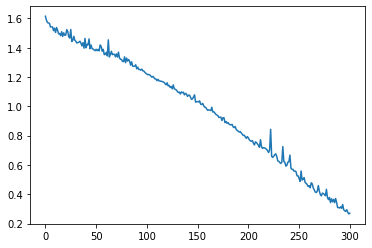

In [ ]:
for i in range(20):
    %time
    ind = np.random.permutation(range(0,25))

    train_dataset, test_dataset = torch.utils.data.Subset(dataset, ind[0:20]),torch.utils.data.Subset(dataset, ind[20:25])

    train_batch = torch.utils.data.DataLoader(train_dataset, 
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=1)

    test_batch = torch.utils.data.DataLoader(test_dataset, 
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=1)
    
    model = UNet_CA_SA(256)
    summary(model.cuda(), (1, 256, 256))

    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    shedule = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=20)
    num_epochs = 1000
    batch_size = 20
    try:
      Trainer(model, train_batch, test_batch, epochs = num_epochs, optimizer=opt, sheduler=shedule)
    except KeyboardInterrupt:
      pass
    
    img, mask = np.zeros(5), np.zeros(5)

    for (x,y) in test_batch:
        img = Variable(model(x.cuda())).cpu().numpy().reshape(5,256,256)
        mask = Variable(y).numpy().reshape(5,256,256)
        
    im, mask = img.reshape(5, -1), mask.reshape(5, -1)
    im.shape, mask.shape

    dice_metric = []
    for i,_ in enumerate(im):
        inter = np.sum(im[i]*mask[i])
        union = (np.sum(im[i])+np.sum(mask[i]))
        dice_metric.append(2*inter/union)
    